In [129]:
## what effect does time have on district (and race or age)
## replace district w location

## is there a stronger correlation between incidents at night by race that spur requests vs incidents at night

In [130]:
import pandas as pd
from lib import standardize_item_numbers
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import f1_score, r2_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy import stats

In [131]:
def clean():
    dfa = pd.read_csv("../data/police_reports/electronic_police_report_2018_2022.csv")
    dfa = dfa.pipe(standardize_item_numbers, ["item_number"])

    dfb = pd.read_csv("../data/real_time_crime_center/rtcc.csv")
    dfb["rtcc_requested"] = "1"
    dfb = dfb.pipe(standardize_item_numbers, ["item_number"])

    df = pd.merge(dfa, dfb, on="item_number", how="outer")
    return df

In [132]:
df = clean()

C:\Users\PC\AppData\Local\Temp\ipykernel_13588\1030734655.py:2: DtypeWarning: Columns (14,20,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfa = pd.read_csv("../data/police_reports/electronic_police_report_2018_2022.csv")


In [133]:
def clean_offender_race(df):
    df.loc[:, "offender_race"] = df.offender_race.str.lower().str.strip()
    
    return df

In [134]:
df.offender_race.value_counts()

BLACK                                        189115
UNKNOWN                                       52840
WHITE                                         28431
HISPANIC                                       2896
ASIAN                                           643
AMER. IND.                                       97
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER        25
Name: offender_race, dtype: int64

In [135]:
df = df.pipe(clean_offender_race).drop_duplicates(subset=["offender_race", "offender_gender", "offender_age", "item_number"])

In [136]:
df.offender_race.value_counts()

black                                        95421
unknown                                      33082
white                                        15832
hispanic                                      1591
asian                                          345
amer. ind.                                      49
native hawaiian or other pacific islander       18
Name: offender_race, dtype: int64

In [137]:
df.groupby("offender_race").rtcc_requested.value_counts()

offender_race  rtcc_requested
amer. ind.     1                    3
asian          1                    8
black          1                 4251
hispanic       1                   57
unknown        1                 1003
white          1                  446
Name: rtcc_requested, dtype: int64

In [138]:
df['occurred_date_time'] = sorted(pd.to_datetime(df['occurred_date_time']))
df['hour'] = df['occurred_date_time'].dt.hour
df = df[~((df.hour.fillna("") == ""))]
df.loc[:, "hour"] = df.hour.astype(int)

In [139]:
df.hour.value_counts()

12    18752
11    15711
15    15615
17    15179
10    15159
0     15122
16    15097
1     15056
20    14471
18    14455
19    14375
21    13653
2     13479
23    13354
13    13322
9     13092
14    12933
22    11898
3     11731
8     11531
4      8825
7      8817
5      6648
6      6335
Name: hour, dtype: int64

In [140]:
top_50_charge_descs_sr = (pd.Series(df.groupby("charge_description")
                                                .rtcc_requested.value_counts()
                                                .sort_values(ascending=False).head(10))
)
top_50_charge_descs_df = (pd.DataFrame(top_50_charge_descs_sr).unstack()
                                                              .reset_index()
)

top_charge_desc_list = [x for x in top_50_charge_descs_df["charge_description"]]

In [141]:
requested_df = df[((df.rtcc_requested == "1"))]
not_requested_df = df[~((df.rtcc_requested == "1"))]

requested_df = requested_df[requested_df.charge_description.isin(top_charge_desc_list)]
not_requested_df = not_requested_df[not_requested_df.charge_description.isin(top_charge_desc_list)]

requested_hours_ar = np.array(requested_df["hour"])
not_requested_hours_ar = np.array(not_requested_df["hour"])

Text(0, 0.5, 'Frequency')

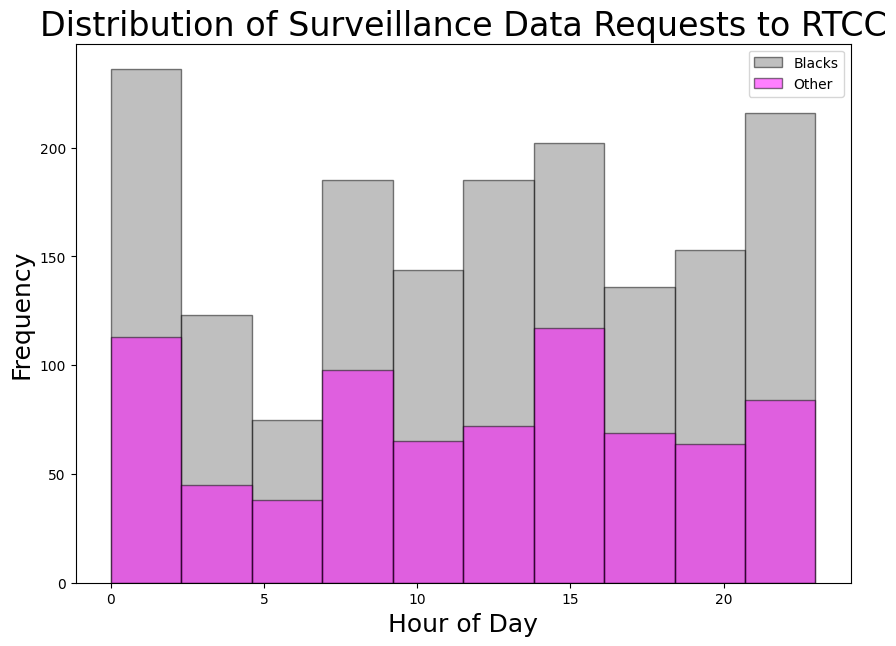

In [142]:
requested_df.loc[:, "offender_race"] = (requested_df.offender_race.str.lower().str.strip().str.replace(r"unknown", "", regex=False)
                                  .str.replace(r"^(?!(black)).*", "0", regex=True)
                                  .str.replace(r"black", "1", regex=False)
)

requested_df[requested_df['offender_race'] == '1'].hour.plot(kind='hist', color='gray', edgecolor='black', alpha=0.5, figsize=(10, 7))
requested_df[requested_df['offender_race'] == '0'].hour.plot(kind='hist', color='magenta', edgecolor='black', alpha=0.5, figsize=(10, 7))
plt.legend(labels=['Blacks', 'Other'])
plt.title('Distribution of Surveillance Data Requests to RTCC', size=24)
plt.xlabel('Hour of Day', size=18)
plt.ylabel('Frequency', size=18)

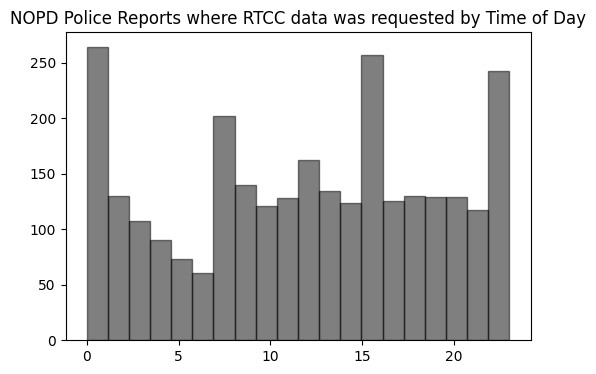

In [143]:
fig, ax = plt.subplots(figsize =(6,4) )
ax.hist(requested_hours_ar, bins =20, color="k", edgecolor = 'black',  alpha=0.5)
ax.set_title("NOPD Police Reports where RTCC data was requested by Time of Day")
plt.show()

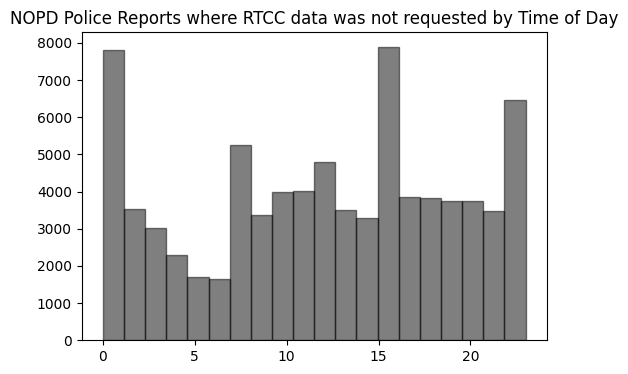

In [144]:
fig, ax = plt.subplots(figsize =(6,4) )
ax.hist(not_requested_hours_ar, bins =20, color="k", edgecolor = 'black',  alpha=0.5)
ax.set_title("NOPD Police Reports where RTCC data was not requested by Time of Day")
plt.show()

In [145]:
df.charge_description.value_counts().head(10)

THEFT                                    27869
SIMPLE BURGLARY                          24536
SIMPLE CRIMINAL DAMAGE TO PROPERTY       13749
THEFT OF A MOTOR VEHICLE                  8683
WARRANT ISSUED BY                         6749
DOMESTIC ABUSE BATTERY                    4510
BATTERY                                   4289
SIMPLE BATTERY                            3894
IDENTITY THEFT                            3435
POSSESSION OF MARIJUANA (1ST OFFENSE)     3034
Name: charge_description, dtype: int64

In [146]:
requested_df = df[((df.rtcc_requested == "1"))]
requested_df.offender_race.groupby(requested_df["rtcc_requested"]).describe()

,count,unique,top,freq
rtcc_requested,,,,
1,5768,6,black,4251


In [147]:
requested_df

,Unnamed: 0,item_number,district,location,disposition,signal_type,signal_description,occurred_date_time,charge_code,charge_description,...,victim_fatal_status,hate_crime,report_type,year,offenderid,offenderstatus,persontype,Signal Code,rtcc_requested,hour
282,237.0,d2077118,2.0,36XX S Roman St,CLOSED,30S,HOMICIDE (SHOOTING),2018-01-01 16:12:00,14 (27) 30.1,ATTEMPT - SECOND DEGREEMURDER,...,Non-fatal,NaN,Supplemental Report,2018.0,NaN,NaN,NaN,30s,1,16
495,373.0,e1274818,5.0,Saint Claude Av & Alvar St,OPEN,30S,HOMICIDE (SHOOTING),2018-01-02 08:00:00,14 30,FIRST DEGREE MURDER,...,Fatal,NaN,Incident Report,2018.0,NaN,NaN,NaN,30,1,8
588,487.0,l2194418,7.0,78XX Sun St,OPEN,30S,HOMICIDE (SHOOTING),2018-01-02 15:53:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2018.0,NaN,NaN,NaN,30S,1,15
707,541.0,j3237918,6.0,31XX Louisiana Avenue Pw,CLOSED,67A,AUTO THEFT,2018-01-02 23:00:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2018.0,NaN,NaN,NaN,107,1,23
734,563.0,g3552218,3.0,Metairie Rd & City Park Av,CLOSED,34S,AGGRAVATED BATTERY (SHOOTING),2018-01-03 01:28:00,14 34.7,AGG. SECOND DEGREE BATTERY,...,Non-fatal,NaN,Supplemental Report,2018.0,NaN,NaN,NaN,34S,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533922,83304.0,b2385022,8.0,005XX Bourbon St,OPEN,67,THEFT,2022-11-18 11:00:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,67,1,11
533944,83326.0,a0325822,5.0,022XX Frenchmen St,CLOSED,64J,ARMED CARJACKING,2022-11-18 21:58:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,64J,1,21
533956,83338.0,j2225922,3.0,043XX Chef Menteur Hw,OPEN,64G,ARMED ROBBERY (GUN),2022-11-19 01:45:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,NaN,1,1
534001,83383.0,a1349122,1.0,013XX N Derbigny St,OPEN,27-64J,ATTEMPTED ARMED CARJACKING,2022-11-20 00:00:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,64 J,1,0


In [148]:
not_requested_df = df[~((df.rtcc_requested == "1"))]
not_requested_df["rtcc_requested"] = "0"

C:\Users\PC\AppData\Local\Temp\ipykernel_13588\3958924517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_requested_df["rtcc_requested"] = "0"


In [149]:
not_requested_df

,Unnamed: 0,item_number,district,location,disposition,signal_type,signal_description,occurred_date_time,charge_code,charge_description,...,victim_fatal_status,hate_crime,report_type,year,offenderid,offenderstatus,persontype,Signal Code,rtcc_requested,hour
0,0.0,d2348218,6.0,23XX Milan St,CLOSED,67,THEFT,2018-01-01 00:00:00,54 186,THEFT,...,Non-fatal,NaN,Supplemental Report,2018.0,NaN,NaN,NaN,NaN,0,0
1,1.0,e1397518,4.0,45XX Macarthur Bd 69,OPEN,27-29S,ATTEMPTED SUICIDE,2018-01-01 00:00:00,NaN,NaN,...,Non-fatal,NaN,Incident Report,2018.0,NaN,NaN,NaN,NaN,0,0
2,2.0,d3450118,3.0,63XX Elysian Fields St,CLOSED,37,AGGRAVATED ASSAULT,2018-01-01 00:00:00,40 966,PROHIBITED ACTS--SCHEDULE I DRUGS,...,Non-fatal,NaN,Incident Report,2018.0,NaN,NaN,NaN,NaN,0,0
8,98.0,d3450118,3.0,63XX Elysian Fields St,CLOSED,37,AGGRAVATED ASSAULT,2018-01-01 00:01:00,14 35,SIMPLE BATTERY,...,Non-fatal,NaN,Incident Report,2018.0,NaN,NaN,NaN,NaN,0,0
16,3.0,e1209118,8.0,15XX Pauger St,OPEN,67,THEFT,2018-01-01 00:10:00,14 67,THEFT,...,Non-fatal,NaN,Incident Report,2018.0,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534030,83411.0,h1343322,1.0,005XX S Norman C Francis Pw,CLOSED,63,TRESPASSING,2022-11-21 11:33:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,NaN,0,11
534031,83412.0,a1527522,3.0,043XX Palmyra St,OPEN,67A,AUTO THEFT,2022-11-21 12:17:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,NaN,0,12
534032,83413.0,g2244222,3.0,043XX Palmyra St,OPEN,62R,SIMPLE BURGLARY (RESIDENCE),2022-11-21 12:23:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,NaN,0,12
534033,83414.0,j2313722,8.0,003XX Saint Charles Av,OPEN,67,THEFT,2022-11-21 15:35:00,NaN,NaN,...,Non-fatal,NaN,Supplemental Report,2022.0,NaN,NaN,NaN,NaN,0,15


In [150]:
not_requested_df = not_requested_df.sample(frac=.2)

dfb = pd.concat([not_requested_df, requested_df])
dfb = dfb[~((dfb.rtcc_requested.fillna("") == ""))]
dfb.shape

(69712, 29)

In [151]:
# dfb = df[df.rtcc_requested == "1"]
dfb['sin_hour'] = np.sin(2 * np.pi * dfb['hour'] / max(dfb['hour'])) 
dfb['cos_hour'] = np.cos(2 * np.pi * dfb['hour'] / max(dfb['hour']))


dfb.loc[:, "rtcc_requested"] = dfb.rtcc_requested.astype(float)

dfb = dfb[~((dfb.offender_race.fillna("") == ""))]
dfb = dfb[~((dfb.rtcc_requested.fillna("") == ""))]
# dfb = dfb[~((dfb.sin_hour.fillna("") == ""))]
# dfb = dfb[~((dfb.cos_hour.fillna("") == ""))]
# dfb = dfb[~((dfb.disposition.fillna("") == ""))]
# dfb = dfb[~((dfb.offender_age.fillna("") == ""))]

In [152]:
# for col in df:
#     if not pd.api.types.is_numeric_dtype(df[col]):
#         df = pd.get_dummies(df, columns=[col], prefix=col, drop_first=True)


dispositions = pd.get_dummies(dfb["disposition"], drop_first=True)
dfb = pd.concat([dfb, dispositions], axis=1)

races = pd.get_dummies(dfb["offender_race"], drop_first=True)
dfb = pd.concat([dfb, races], axis=1)


In [153]:
dfb

,Unnamed: 0,item_number,district,location,disposition,signal_type,signal_description,occurred_date_time,charge_code,charge_description,...,sin_hour,cos_hour,OPEN,UNFOUNDED,asian,black,hispanic,native hawaiian or other pacific islander,unknown,white
451947,2378.0,j2892222,7.0,Willowbrook Dr & Caddo Pl,OPEN,64J,ARMED CARJACKING,2022-01-10 02:30:00,14 64.2,CARJACKING,...,0.519584,0.854419,1,0,0,0,0,0,1,0
370043,21935.0,j0174521,7.0,074XX Read Bd,CLOSED,65,SIMPLE ROBBERY,2021-03-22 16:32:00,14 65,SIMPLE ROBBERY,...,-0.942261,-0.334880,0,0,0,1,0,0,0,0
337357,92246.0,k3583820,3.0,5115 PRATT DR,OPEN,67,THEFT,2020-11-24 11:25:00,54 186,THEFT,...,0.136167,-0.990686,1,0,0,0,0,0,0,1
128813,5719.0,a2321919,4.0,2201 WESTBEND PW #H,CLOSED,21J,MISSING/RUNAWAY JUVENILE,2019-01-17 21:00:00,NaN,NaN,...,-0.519584,0.854419,0,0,0,1,0,0,0,0
36358,35330.0,g3477518,6.0,8XX Aline St,OPEN,62C,SIMPLE BURGLARY (VEHICLE),2018-04-25 01:30:00,NaN,NaN,...,0.269797,0.962917,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532717,82049.0,a1289022,5.0,018XX Touro St,OPEN,64J,ARMED CARJACKING,2022-11-07 11:52:00,14 64,ARMED ROBBERY,...,0.136167,-0.990686,1,0,0,1,0,0,0,0
533577,82959.0,b2367722,6.0,Saint Charles Av & Thalia St,CLOSED,95G,ILLEGAL CARRYING OF A GUN,2022-11-13 15:15:00,14 95,ILLEGAL CARRYING OF WEAPON,...,-0.816970,-0.576680,0,0,0,1,0,0,0,0
533593,82977.0,b2375122,8.0,002XX Bourbon St,OPEN,65P,PROPERTY SNATCHING,2022-11-13 19:30:00,14 65,SIMPLE ROBBERY,...,-0.887885,0.460065,1,0,0,0,0,0,0,1
533627,83013.0,b2383422,6.0,013XX Saint Charles Av,CLOSED,95G,ILLEGAL CARRYING OF A GUN,2022-11-14 00:15:00,14 95,ILLEGAL CARRYING OF WEAPON,...,0.000000,1.000000,0,0,0,1,0,0,0,0


In [154]:
dfc = dfb[["rtcc_requested","asian","black", "hispanic","white"]]

In [155]:
corr_df = pd.DataFrame(columns=["r", "p"])
for col in dfc:
    if pd.api.types.is_numeric_dtype(dfc[col]):
        r, p = stats.pearsonr(dfb.rtcc_requested, dfc[col])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]
corr_df

,r,p
rtcc_requested,1.000,0.000
asian,-0.007,0.181
black,0.071,0.000
hispanic,-0.005,0.343
white,-0.038,0.000


In [156]:
train, test = train_test_split(dfc, test_size=0.2)

x_test = np.array(test)
y_test = np.array(test.rtcc_requested)

x_train = np.array(train)
y_train = np.array(train.rtcc_requested)

In [157]:
model = sm.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.372e+34
Date:                Sun, 08 Jan 2023   Prob (F-statistic):                        0.00
Time:                        12:34:51   Log-Likelihood:                      9.4138e+05
No. Observations:               27093   AIC:                                 -1.883e+06
Df Residuals:                   27088   BIC:                                 -1.883e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [158]:
lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True,
    ).fit(x_train, y_train)


sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(x_train, y_train)


sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)
test["scores_lr"] = y_pred_lr
lrs = []
for score in test["scores_lr"]:
    lrs.append(r2_score(y_test, y_pred_lr))

y_pred_sgd = sgd.predict(x_test)
test["scores_sgd"] = y_pred_sgd
sgds = []
for score in test["scores_sgd"]:
    sgds.append(f1_score(y_test, y_pred_sgd, average="weighted"))


y_pred_sgd_huber = sgd_huber.predict(x_test)
test["scores_sgd_huber"] = y_pred_sgd_huber
sgds_huber = []
for score in test["scores_sgd_huber"]:
    sgds_huber.append(f1_score(y_test, y_pred_sgd_huber, average="weighted"))


print(f'Logistic Regression Val f1: {np.mean(lrs):.3f} +- {np.std(lrs):.3f}')
print(f'Logistic Regression SGD f1: {np.mean(sgds):.3f} +- {np.std(sgds):.3f}')
print(f'SVM Huber Val f1: {np.mean(sgds_huber):.3f} +- {np.std(sgds_huber):.3f}')

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Logistic Regression Val f1: 1.000 +- 0.000
Logistic Regression SGD f1: 1.000 +- 0.000
SVM Huber Val f1: 0.747 +- 0.000


Feature: 0, Score: 13.77222
Feature: 1, Score: -0.00625
Feature: 2, Score: 0.15452
Feature: 3, Score: 0.00423
Feature: 4, Score: -0.05026


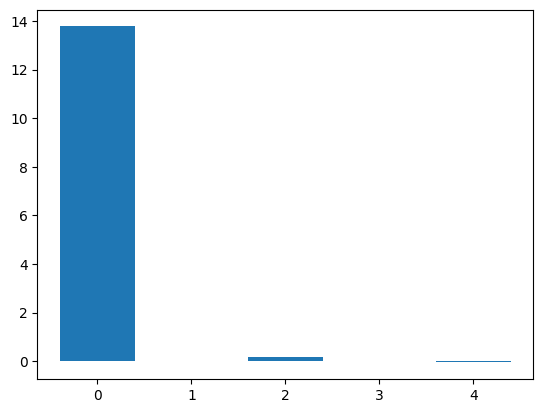

In [159]:
log_feat_importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(log_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(log_feat_importance))], log_feat_importance)
plt.show()

Feature: 0, Score: 12.04618
Feature: 1, Score: -0.00574
Feature: 2, Score: 0.15705
Feature: 3, Score: 0.00381
Feature: 4, Score: -0.05145


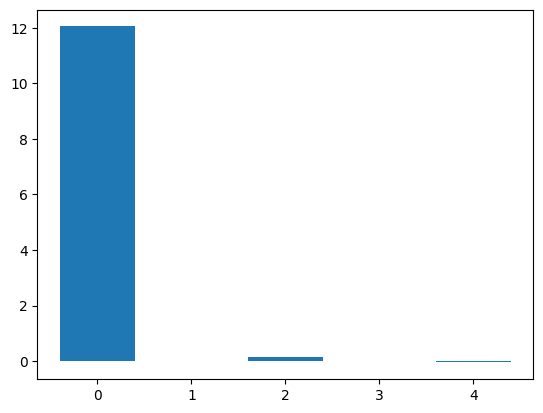

In [160]:
log_feat_importance = sgd.coef_[0]
# summarize feature importance
for i,v in enumerate(log_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(log_feat_importance))], log_feat_importance)
plt.show()

r2 score:  1.0
Mean_sqrd_error:  1.6372617635471042e-27
Root_mean_squared error:  4.046309137407947e-14
Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000


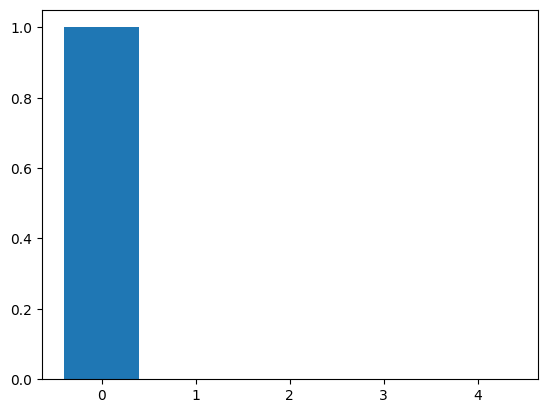

In [161]:
LR = LinearRegression()

LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)

print("r2 score: ", score)
print("Mean_sqrd_error: ", mean_squared_error(y_test,y_prediction))
print("Root_mean_squared error: ", np.sqrt(mean_squared_error(y_test,y_prediction)))

lr_feature_importance = LR.coef_

for i,v in enumerate(lr_feature_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
 
plt.bar([x for x in range(len(lr_feature_importance))], lr_feature_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000


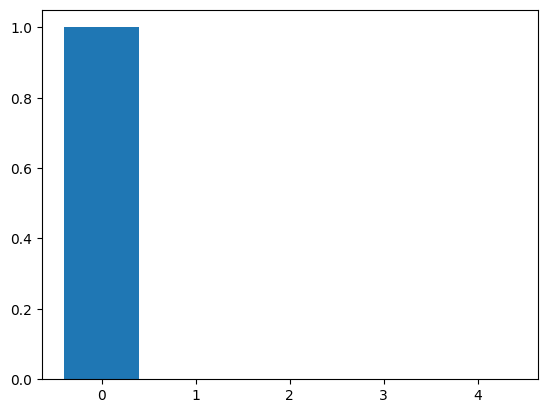

In [162]:
dtr = DecisionTreeRegressor()

dtr.fit(x_train, y_train)

dtr_feat_importance = dtr.feature_importances_

for i,v in enumerate(dtr_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(dtr_feat_importance))], dtr_feat_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000


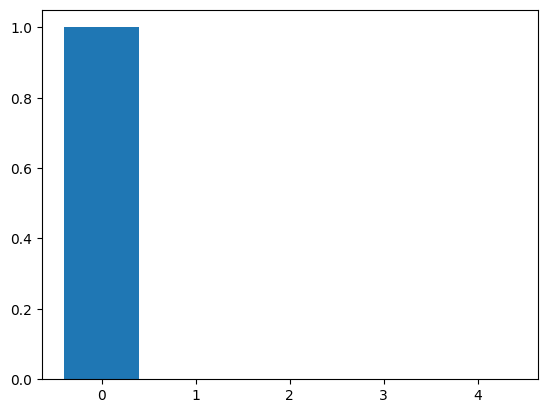

In [163]:
dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)

dtc_feat_importance = dtc.feature_importances_

for i,v in enumerate(dtc_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(dtc_feat_importance))], dtc_feat_importance)
plt.show()

Feature: 0, Score: 1.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000


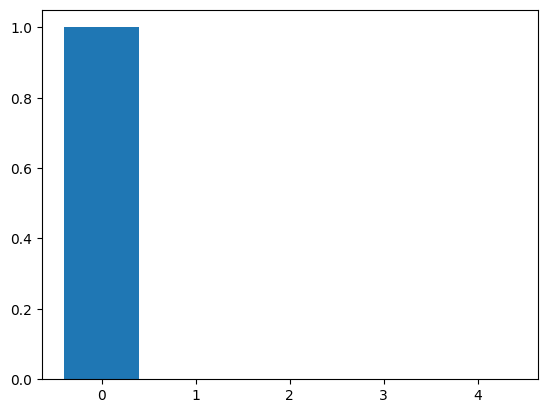

In [164]:
rfr = RandomForestRegressor()

rfr.fit(x_train, y_train)

rfr_feat_importance = rfr.feature_importances_

for i,v in enumerate(rfr_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(rfr_feat_importance))], rfr_feat_importance)
plt.show()

Feature: 0, Score: 0.99792
Feature: 1, Score: 0.00002
Feature: 2, Score: 0.00167
Feature: 3, Score: 0.00001
Feature: 4, Score: 0.00039


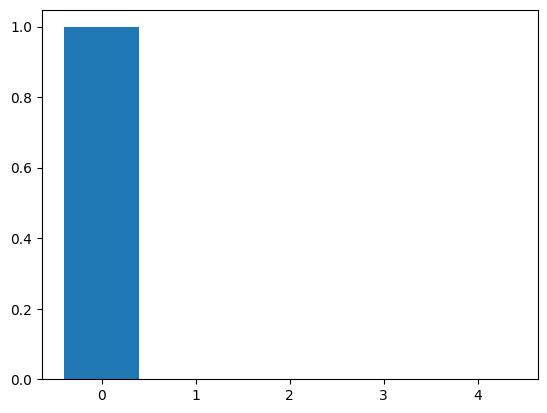

In [165]:
rfc = RandomForestClassifier()

rfc.fit(x_train, y_train)

rfc_feat_importance = rfc.feature_importances_

for i,v in enumerate(rfc_feat_importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(rfc_feat_importance))], rfc_feat_importance)
plt.show()